In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('merge_data_2018_2022.csv')

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              

from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from pmdarima import auto_arima

## Setting Freq = 'H'

In [3]:
df = df.set_index('DATETIME')
df.index = pd.to_datetime(df.index)
df=df.loc[~df.index.duplicated(), :]
df=df.asfreq('H')
df.index

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2022-08-28 15:00:00', '2022-08-28 16:00:00',
               '2022-08-28 17:00:00', '2022-08-28 18:00:00',
               '2022-08-28 19:00:00', '2022-08-28 20:00:00',
               '2022-08-28 21:00:00', '2022-08-28 22:00:00',
               '2022-08-28 23:00:00', '2022-08-29 00:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=40824, freq='H')

### Subseting from 2018-01-01 to 2018-12-31 for training

In [5]:
filt1 = (df.index>=pd.to_datetime('2018-01-01'))
df2 = df.loc[filt1]

filt2 = (df2.index<=pd.to_datetime('2019-01-09'))
df2 = df2.loc[filt2]
df2.index

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2019-01-08 15:00:00', '2019-01-08 16:00:00',
               '2019-01-08 17:00:00', '2019-01-08 18:00:00',
               '2019-01-08 19:00:00', '2019-01-08 20:00:00',
               '2019-01-08 21:00:00', '2019-01-08 22:00:00',
               '2019-01-08 23:00:00', '2019-01-09 00:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=8952, freq='H')

## Checking for missing values

In [4]:
df2[['WAKEWE_ALL..RTLMP.']].isnull().value_counts()

WAKEWE_ALL..RTLMP.
False                 40819
True                      5
dtype: int64

## Missing value imputation

In [9]:
df2['WAKEWE_ALL..RTLMP.'].fillna(method='bfill', inplace=True)
df2[['WAKEWE_ALL..RTLMP.']].isnull().value_counts()

WAKEWE_ALL..RTLMP.
False                 8952
dtype: int64

## Dealing with outliers

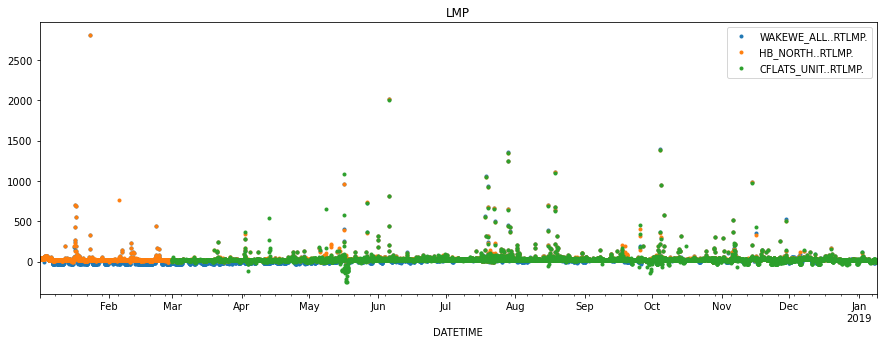

In [10]:
df2[['WAKEWE_ALL..RTLMP.', 'HB_NORTH..RTLMP.', 'CFLATS_UNIT..RTLMP.']].plot(style = '.', 
                                                                            figsize = (15,5), title = 'LMP')
plt.show()

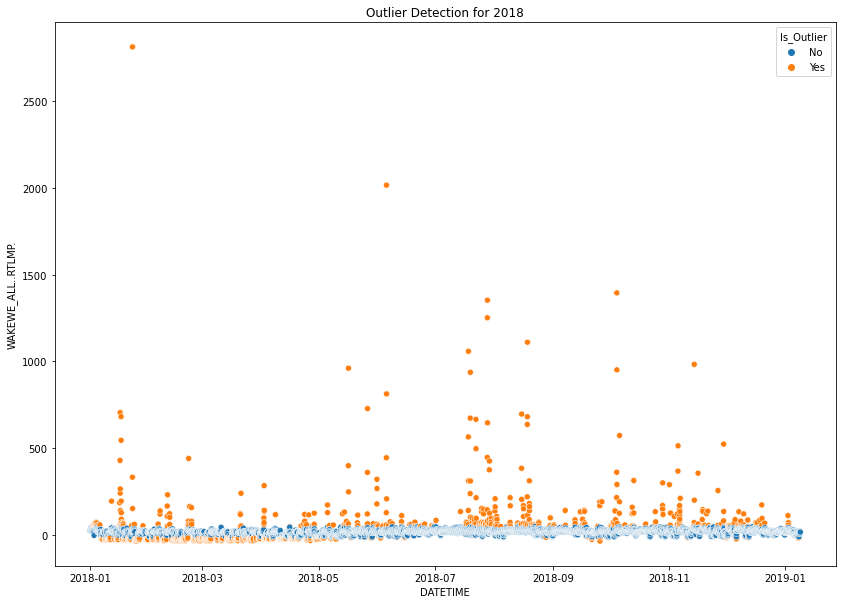

In [11]:
# IQR
import numpy as np

Q1 = np.percentile(df2['WAKEWE_ALL..RTLMP.'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df2['WAKEWE_ALL..RTLMP.'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
# Upper bound
upper = np.where(df2['WAKEWE_ALL..RTLMP.'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df2['WAKEWE_ALL..RTLMP.'] <= (Q1-1.5*IQR))
df2['Is_Outlier'] = df2['WAKEWE_ALL..RTLMP.'].map(lambda x: 'Yes' if x >= (Q3+1.5*IQR) or x <= (Q1-1.5*IQR) else 'No')
df3 = df2[['WAKEWE_ALL..RTLMP.', 'Is_Outlier']]

fig = plt.gcf()
fig.set_size_inches(14,10)
sns.scatterplot(data=df3, x = df3.index, y = 'WAKEWE_ALL..RTLMP.', hue = 'Is_Outlier')
plt.title('Outlier Detection for 2018')
plt.show()

## KNN Outlier Smoothing

In [12]:
df2['Is_KNN_Outlier'] = df2['WAKEWE_ALL..RTLMP.'].map(lambda x: np.nan if x >= 400 or x <= -50 else x)

In [13]:
df2['Is_KNN_Outlier'].isna().sum()

33

In [14]:
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=5, add_indicator=True)
knn.fit(df2[['Is_KNN_Outlier']])
cc = pd.DataFrame(knn.transform(df2[['Is_KNN_Outlier']]), columns = ['A', 'B'])
cc[['A']].isna().sum()

A    0
dtype: int64

In [15]:
cc = cc.set_index(df2.index)
df2['KNN_Transformed'] = cc['A']


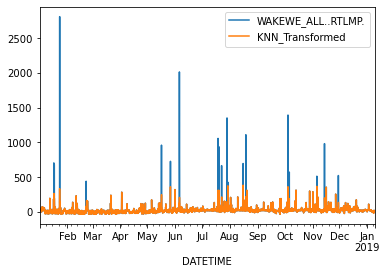

In [16]:
df2[['WAKEWE_ALL..RTLMP.','KNN_Transformed']].plot()

plt.show()

## Median Smoothing

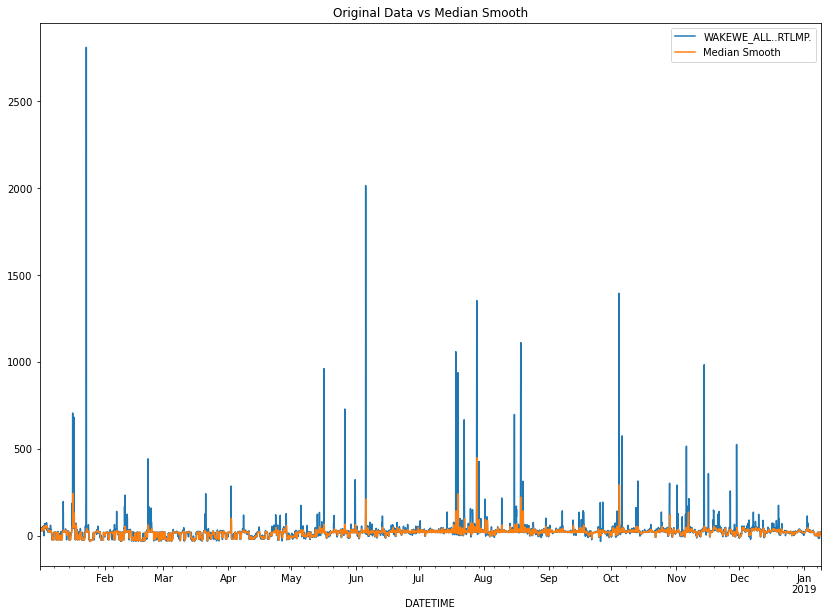

In [17]:
rolling = df2['WAKEWE_ALL..RTLMP.'].rolling(window=7)
df2['Median Smooth'] = rolling.median()


df2[['WAKEWE_ALL..RTLMP.','Median Smooth']].plot()

fig = plt.gcf()
fig.set_size_inches(14,10)
plt.title('Original Data vs Median Smooth')
plt.show()

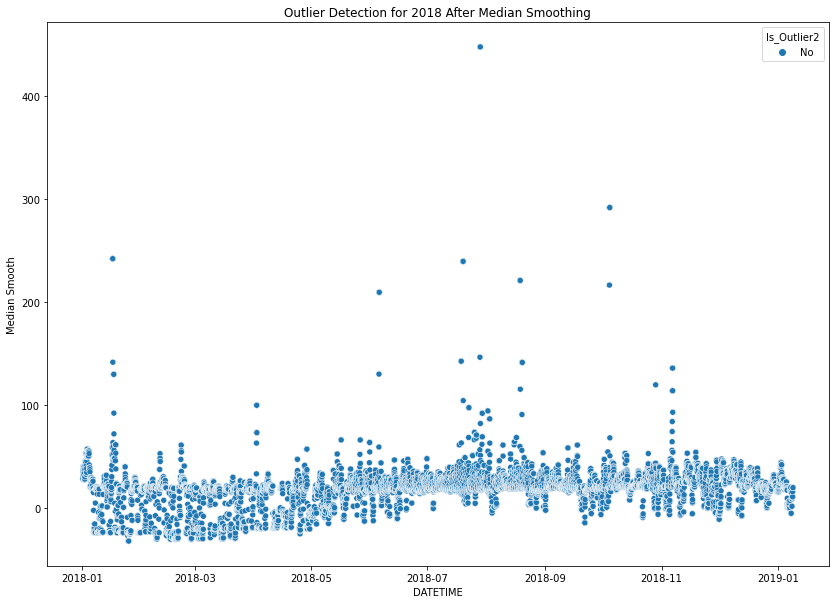

In [18]:
import numpy as np

Q1 = np.percentile(df2['Median Smooth'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df2['Median Smooth'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
# Upper bound
upper = np.where(df2['Median Smooth'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df2['Median Smooth'] <= (Q1-1.5*IQR))
df2['Is_Outlier2'] = df2['Median Smooth'].map(lambda x: 'Yes' if x >= (Q3+1.5*IQR) or x <= (Q1-1.5*IQR) else 'No')
df3 = df2[['Median Smooth', 'Is_Outlier2']]

fig = plt.gcf()
fig.set_size_inches(14,10)
sns.scatterplot(data=df3, x = df3.index, y = 'Median Smooth', hue = 'Is_Outlier2')
plt.title('Outlier Detection for 2018 After Median Smoothing')
plt.show()

In [19]:
def styling_specific_cell(x,row_idx,col_idx):
    color = 'background-color: blue; color: violet'
    df_styler = pd.DataFrame('', index=x.index, columns=x.columns)
    df_styler.iloc[row_idx, col_idx] = color
    return df_styler
idx_r = 3  
idx_c = 0   
dff = df2[['WAKEWE_ALL..RTLMP.','Median Smooth']].head(10)
dff.style.apply(styling_specific_cell,row_idx = idx_r, col_idx = idx_c, axis = None) 

#dff.style.apply(styling_specific_cell,row_idx = 3, col_idx = 0, axis = None) 


,WAKEWE_ALL..RTLMP.,Median Smooth
DATETIME,,
2018-01-01 01:00:00,27.637500,nan
2018-01-01 02:00:00,27.700000,nan
2018-01-01 03:00:00,27.440000,nan
2018-01-01 04:00:00,27.957500,nan
2018-01-01 05:00:00,28.807500,nan
2018-01-01 06:00:00,31.887500,nan
2018-01-01 07:00:00,35.052500,27.957500
2018-01-01 08:00:00,36.655000,28.807500
2018-01-01 09:00:00,40.237500,31.887500


In [21]:
df2[['WAKEWE_ALL..RTLMP.','Medf2[['WAKEWE_ALL..RTLMP.','Median Smooth']].plot()dian Smooth']].tail()

## Trend & seasonality decompose of the original data

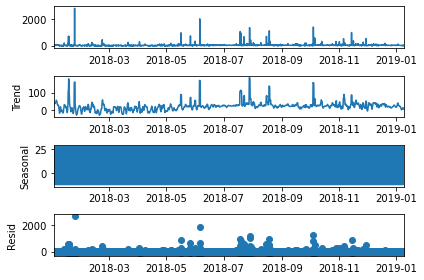

In [15]:
#aa = df2.resample(rule='D').sum()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df2[['WAKEWE_ALL..RTLMP.']], model ='additive')

fig = decomposition.plot()
plt.show()

## Trend & seasonality decompose of the transformed data

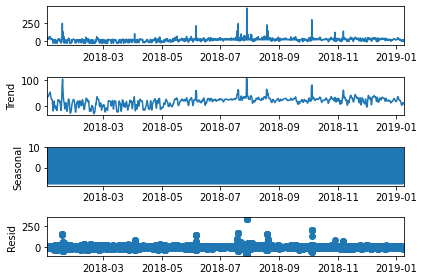

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df2[['Median Smooth']].dropna(), model ='additive')

fig = decomposition.plot()
plt.show()

## Augumented Dickey Fuller Test for Stationarity

In [24]:
from statsmodels.tsa.stattools import adfuller as ADF

series1 = df2['WAKEWE_ALL..RTLMP.'] 
series2 = df2['Median Smooth'].dropna()

result1 = ADF(series1)
result2 = ADF(series2)

print('ADF Statistic for original data: ', result1[0])
print('P-value for original data: {:.20f}'.format(result1[1]))

print('ADF Statistic for transformed data: ', result2[0])
print('P-value for transformed data: {:.20f}'.format(result2[1]))

ADF Statistic for original data:  -13.353983093192191
P-value for original data: 0.00000000000000000000
ADF Statistic for transformed data:  -11.029768189467411
P-value for transformed data: 0.00000000000000000006


## Berush Pagan Test for Heteroskedacity

In [18]:
from statsmodels.stats.diagnostic import het_breuschpagan as BP
import statsmodels.api as sm
from statsmodels.formula.api import ols

bp_data = df2[['WAKEWE_ALL..RTLMP.']].copy()
bp_data['LMP'] = bp_data['WAKEWE_ALL..RTLMP.']
bp_data['Time_Period'] = range(1, len(bp_data)+1) # Convert time series points into consecutive ints

formula = 'LMP ~ Time_Period' # ie 'WAKEWE_ALL..RTLMP.' depends on Time Period (OLS auto adds Y intercept)

# Next we apply Ordinary Linear Square baseline regression model - as baseline test
model = ols(formula, bp_data).fit()

result = BP(model.resid, model.model.exog)

print('BP Statistic for original data: ', result[0])
print('P-value for original data: {:.20f}'.format(result[1]))

BP Statistic for original data:  1.2367661693824497
P-value for original data: 0.26609520324883356723


## Berush Pagan Test for Heteroskedacity

In [19]:
from statsmodels.stats.diagnostic import het_breuschpagan as BP
import statsmodels.api as sm
from statsmodels.formula.api import ols

bp_data = df2[['Median Smooth']].copy()
bp_data['LMP'] = bp_data['Median Smooth']
bp_data['Time_Period'] = range(1, len(bp_data)+1) # Convert time series points into consecutive ints

formula = 'LMP ~ Time_Period' # ie 'Median Smooth' depends on Time Period (OLS auto adds Y intercept)

# Next we apply Ordinary Linear Square baseline regression model - as baseline test
model = ols(formula, bp_data).fit()

result = BP(model.resid, model.model.exog)

print('BP Statistic transformed data: ', result[0])
print('P-value transformed data: {:.20f}'.format(result[1]))

BP Statistic transformed data:  6.813488631316983
P-value transformed data: 0.00904718417448469384


## Model Parameter Grid Search

In [ ]:
train1 = df2[['WAKEWE_ALL..RTLMP.']].iloc[:8759]
train2 = df2[['Median Smooth']].iloc[:8759]
test = df2[['WAKEWE_ALL..RTLMP.']].iloc[8759:8784]

model11 = auto_arima(train1['WAKEWE_ALL..RTLMP.'],start_p=0,
    d=0,
    start_q=0,
    max_p=5,
    max_d=2,
    max_q=5, seasonal=False,m=24).summary()

In [20]:
df2['PEAKTYPE_num']= pd.factorize(df2.PEAKTYPE)[0]

In [21]:
df2.columns

Index(['Unnamed: 0', 'index', 'CFLATS_UNIT..RTLMP.', 'HB_NORTH..RTLMP.',
       'WAKEWE_ALL..RTLMP.', 'CFLATS_UNIT..DALMP.', 'HB_NORTH..DALMP.',
       'WAKEWE_ALL..DALMP.', 'ERCOT..LOAD_FORECAST.', 'ERCOT..RTLOAD.',
       'ERCOT..WIND_STWPF.', 'ERCOT..WINDDATA.', 'GR_PANHANDLE..WIND_STWPF.',
       'GR_PANHANDLE..WINDDATA.', 'GR_WEST..WIND_STWPF.',
       'ERCOT..WIND_STWPF..1', 'GR_WEST..WINDDATA.',
       'Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.', 'WAKEWE_ALL..DARTLMP.',
       'TYLRWIND_RN..DARTLMP.',
       'West.Texas.Export..ERCOT_DA_GENERIC_CONSTRAINTS.',
       'ERCOT..SOLAR_PVGRPP.', 'HOURENDING', 'MARKETDAY', 'PEAKTYPE', 'MONTH',
       'YEAR', 'Is_Outlier', 'Is_KNN_Outlier', 'Transform2', 'KNN_Transformed',
       'Median Smooth', 'PEAKTYPE_num'],
      dtype='object')

In [22]:
df2['ERCOT..LOAD_FORECAST.'].fillna(method = 'bfill', inplace = True)

In [27]:
df2['ERCOT..WINDDATA.'].fillna(method = 'bfill', inplace = True)

In [23]:
df2['ERCOT..WIND_STWPF.'].fillna(method = 'bfill', inplace = True)

In [24]:
df2['Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.'].fillna(method = 'bfill', inplace = True)

In [25]:
df2['ERCOT..SOLAR_PVGRPP.'].fillna(method = 'bfill', inplace = True)

In [28]:
df2[['ERCOT..WINDDATA.', 'ERCOT..LOAD_FORECAST.', 'ERCOT..WIND_STWPF.',
'Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.', 'ERCOT..SOLAR_PVGRPP.', 'PEAKTYPE_num']].isna().sum()

ERCOT..WINDDATA.                            0
ERCOT..LOAD_FORECAST.                       0
ERCOT..WIND_STWPF.                          0
Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.    0
ERCOT..SOLAR_PVGRPP.                        0
PEAKTYPE_num                                0
dtype: int64

## Model building (Day Ahead)

In [22]:
train1 = df2[['WAKEWE_ALL..RTLMP.']].iloc[:8759]
train2 = df2[['Median Smooth']].iloc[:8759]
train3 = df2[['KNN_Transformed']].iloc[:8759]
#train_exo = df2[['ERCOT..WINDDATA.', 'ERCOT..LOAD_FORECAST.', 'ERCOT..WIND_STWPF.',
#'Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.', 'ERCOT..SOLAR_PVGRPP.', 'PEAKTYPE_num']].iloc[:8759]
test1 = df2[['WAKEWE_ALL..RTLMP.']].iloc[8759:8784]
test2 = df2[['Median Smooth']].iloc[8759:8784]
test3 = df2[['KNN_Transformed']].iloc[8759:8784]

In [30]:
model1 = SARIMAX(train2['Median Smooth'],train_exo,
                 order=(0, 1, 5),seasonal_order=(0, 0, 0, 24))
results1 = model1.fit()
results1.summary()

C:\Users\Tagbo Aroh\Miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Median Smooth   No. Observations:                 8759
Model:               SARIMAX(0, 1, 5)   Log Likelihood              -31044.067
Date:                Wed, 26 Oct 2022   AIC                          62112.135
Time:                        13:11:21   BIC                          62197.067
Sample:                    01-01-2018   HQIC                         62141.075
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
ERCOT..WINDDATA.                            -0.0007      0.000     -3.159      0.002      -0.001      -0.000
ERCOT..LOAD_FORECAST.                        0.0007   7.12e-05      9.446      0.000       0.001       0.001
ERCOT..WIND_STWPF.                          -0.0008      0.000     -2.975      0.003      -0.001      -0.000
Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.    -0.0040      0.004     -0.909      0.363      -0.013       0.005
ERCOT..SOLAR_PVGRPP.                        -0.0005      0.001     -0.576      0.565      -0.002       0.001
PEAKTYPE_num                                -0.4178      0.255     -1.636      0.102      -0.918       0.083
ma.L1                                        0.0923      0.002     38.545      0.000       0.088       0.097
ma.L2                                       -0.0782      0.005    -16.156      0.000      -0.088      -0.069
ma.L3                                        0.0353      0.004      8.256      0.000       0.027       0.044
ma.L4                                       -0.3957      0.002   -196.585      0.000      -0.400      -0.392
ma.L5                                       -0.2819      0.003   -111.976      0.000      -0.287      -0.277
sigma2                                      71.5033      0.156    458.613      0.000      71.198      71.809
===================================================================================
Ljung-Box (L1) (Q):                   7.45   Jarque-Bera (JB):          46870267.04
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             6.66
Prob(H) (two-sided):                  0.00   Kurtosis:                       361.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
start=len(train1)
end=len(train1)+len(test2)-1
predictions1 = results1.predict(start=start, end=end,
exog = df2[['ERCOT..WINDDATA.', 'ERCOT..LOAD_FORECAST.', 'ERCOT..WIND_STWPF.',
            'Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.', 
            'ERCOT..SOLAR_PVGRPP.', 'PEAKTYPE_num']].iloc[8759:8784])
import numpy as np

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
err1 = smape(df2['Median Smooth'].iloc[8759:8784], predictions1)
print('SMAPE for ARIMA on the transformed data: ', "{:.4}%".format(err1))

SMAPE for ARIMA on the transformed data:  18.76%


In [33]:
train_exo2 = df2[['ERCOT..WINDDATA.', 'ERCOT..LOAD_FORECAST.','PEAKTYPE_num']].iloc[:8759]
model1 = SARIMAX(train2['Median Smooth'],train_exo2,
                 order=(0, 1, 5),seasonal_order=(0, 0, 0, 24))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Median Smooth   No. Observations:                 8759
Model:               SARIMAX(0, 1, 5)   Log Likelihood              -31051.949
Date:                Wed, 26 Oct 2022   AIC                          62121.898
Time:                        13:13:11   BIC                          62185.598
Sample:                    01-01-2018   HQIC                         62143.603
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ERCOT..WINDDATA.         -0.0014      0.000    -10.506      0.000      -0.002      -0.001
ERCOT..LOAD_FORECAST.     0.0007   7.09e-05      9.819      0.000       0.001       0.001
PEAKTYPE_num             -0.3582      0.255     -1.404      0.160      -0.858       0.142
ma.L1                     0.1148      0.002     51.641      0.000       0.110       0.119
ma.L2                    -0.0725      0.005    -15.714      0.000      -0.082      -0.063
ma.L3                     0.0148      0.004      3.668      0.000       0.007       0.023
ma.L4                    -0.4066      0.002   -201.697      0.000      -0.411      -0.403
ma.L5                    -0.2800      0.002   -114.778      0.000      -0.285      -0.275
sigma2                   71.6115      0.148    482.865      0.000      71.321      71.902
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):          45038165.57
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             6.46
Prob(H) (two-sided):                  0.00   Kurtosis:                       354.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
start=len(train1)
end=len(train1)+len(test)-1
predictions1 = results1.predict(start=start, end=end,
exog = df2[['ERCOT..WINDDATA.', 
            'ERCOT..LOAD_FORECAST.',
            'PEAKTYPE_num']].iloc[8759:8784])

err1 = smape(df2['Median Smooth'].iloc[8759:8784], predictions1)
print('SMAPE for ARIMA on the transformed data: ', "{:.4}%".format(err1))

SMAPE for ARIMA on the transformed data:  17.48%


In [34]:
train_exo2 = df2[['ERCOT..WINDDATA.', 'ERCOT..LOAD_FORECAST.','PEAKTYPE_num']].iloc[:8759]
model1 = SARIMAX(train3['KNN_Transformed'],train_exo,
                 order=(0, 1, 5),seasonal_order=(0, 0, 0, 24))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        KNN_Transformed   No. Observations:                 8759
Model:               SARIMAX(0, 1, 5)   Log Likelihood              -38672.135
Date:                Wed, 26 Oct 2022   AIC                          77368.270
Time:                        13:14:16   BIC                          77453.203
Sample:                    01-01-2018   HQIC                         77397.210
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
ERCOT..WINDDATA.                            -0.0029      0.001     -5.087      0.000      -0.004      -0.002
ERCOT..LOAD_FORECAST.                        0.0011   7.88e-05     14.035      0.000       0.001       0.001
ERCOT..WIND_STWPF.                          -0.0004      0.001     -0.776      0.438      -0.002       0.001
Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.     0.0100      0.006      1.705      0.088      -0.001       0.021
ERCOT..SOLAR_PVGRPP.                        -0.0041      0.001     -3.998      0.000      -0.006      -0.002
PEAKTYPE_num                                -0.0326      0.424     -0.077      0.939      -0.863       0.798
ma.L1                                       -0.6067      0.003   -192.949      0.000      -0.613      -0.601
ma.L2                                       -0.1106      0.004    -25.410      0.000      -0.119      -0.102
ma.L3                                       -0.0376      0.004     -9.124      0.000      -0.046      -0.030
ma.L4                                       -0.0525      0.007     -7.671      0.000      -0.066      -0.039
ma.L5                                       -0.0669      0.009     -7.264      0.000      -0.085      -0.049
sigma2                                     411.9611      1.706    241.456      0.000     408.617     415.305
===================================================================================
Ljung-Box (L1) (Q):                   7.61   Jarque-Bera (JB):           2442877.78
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             5.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        83.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
start=len(train1)
end=len(train1)+len(test3)-1
predictions1 = results1.predict(start=start, end=end,
exog = df2[['ERCOT..WINDDATA.', 'ERCOT..LOAD_FORECAST.', 'ERCOT..WIND_STWPF.',
            'Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.', 
            'ERCOT..SOLAR_PVGRPP.', 'PEAKTYPE_num']].iloc[8759:8784])

err1 = smape(df2['KNN_Transformed'].iloc[8759:8784], predictions1)
print('SMAPE for ARIMA on the transformed data: ', "{:.4}%".format(err1))

SMAPE for ARIMA on the transformed data:  57.52%


In [96]:
df2['Transform2'].iloc[8759:8784]
predictions1

2019-01-01 00:00:00     7.018107
2019-01-01 01:00:00     3.477400
2019-01-01 02:00:00     2.260532
2019-01-01 03:00:00     2.416692
2019-01-01 04:00:00     2.407805
2019-01-01 05:00:00     3.184973
2019-01-01 06:00:00     6.927762
2019-01-01 07:00:00    11.064183
2019-01-01 08:00:00    14.455611
2019-01-01 09:00:00    17.267345
2019-01-01 10:00:00    22.141665
2019-01-01 11:00:00    26.618302
2019-01-01 12:00:00    28.910123
2019-01-01 13:00:00    30.290827
2019-01-01 14:00:00    30.887700
2019-01-01 15:00:00    32.410641
2019-01-01 16:00:00    33.991873
2019-01-01 17:00:00    36.242214
2019-01-01 18:00:00    39.291636
2019-01-01 19:00:00    42.344579
2019-01-01 20:00:00    41.318399
2019-01-01 21:00:00    41.693632
2019-01-01 22:00:00    40.858118
2019-01-01 23:00:00    39.883057
2019-01-02 00:00:00    38.091552
Freq: H, Name: predicted_mean, dtype: float64

In [29]:
model1 = SARIMAX(train1['WAKEWE_ALL..RTLMP.'],
                 order=(0, 1, 5),seasonal_order=(0, 0, 0, 24))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     WAKEWE_ALL..RTLMP.   No. Observations:                 8759
Model:               SARIMAX(0, 1, 5)   Log Likelihood              -47403.420
Date:                Wed, 02 Nov 2022   AIC                          94818.841
Time:                        13:32:57   BIC                          94861.307
Sample:                    01-01-2018   HQIC                         94833.310
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4503      0.001   -427.260      0.000      -0.452      -0.448
ma.L2         -0.2834      0.006    -49.569      0.000      -0.295      -0.272
ma.L3         -0.1493      0.012    -12.614      0.000      -0.173      -0.126
ma.L4         -0.0677      0.023     -2.911      0.004      -0.113      -0.022
ma.L5         -0.0422      0.018     -2.398      0.016      -0.077      -0.008
sigma2      2942.0174      2.175   1352.899      0.000    2937.755    2946.280
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):         278739012.74
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            19.85
Prob(H) (two-sided):                  0.00   Kurtosis:                       876.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
start=len(train1)
end=len(train1)+len(test1)-1
predictions1 = results1.predict(start=start, end=end, dynamic=False,
                                typ='levels').rename('Predictions from model on original data')
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
err1 = smape(df2['WAKEWE_ALL..RTLMP.'].iloc[8759:8784], predictions1)
print('SMAPE for ARIMA on the transformed data: ', "{:.4}%".format(err1))

SMAPE for ARIMA on the transformed data:  24.32%


In [35]:
forecast = results1.get_forecast(24)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.2)
#print(yhat)
yhat_conf_int['length'] = yhat_conf_int['upper WAKEWE_ALL..RTLMP.'] - yhat_conf_int['lower WAKEWE_ALL..RTLMP.']
print('The average prediction interval length for day ahead: ',yhat_conf_int['length'].mean())

The average prediction interval length for day ahead:  162.58980239269283


In [34]:
test_week = df2[['WAKEWE_ALL..RTLMP.']].iloc[8759:8928]
start=len(train1)
end=len(train1)+len(test_week)-1
week_ahead_predictions1 = results1.predict(start=start, end=end, dynamic=False,
                                typ='levels')
err1 = smape(df2['WAKEWE_ALL..RTLMP.'].iloc[8759:8928], week_ahead_predictions1)
print('SMAPE for ARIMA on the transformed data for week ahead: ', "{:.4}%".format(err1))

SMAPE for ARIMA on the transformed data for week ahead:  58.29%


In [35]:
forecast = results1.get_forecast(24)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.2)
#print(yhat)
yhat_conf_int['length'] = yhat_conf_int['upper Median Smooth'] - yhat_conf_int['lower Median Smooth']
print('The average prediction interval length for day ahead: ',yhat_conf_int['length'].mean())

The average prediction interval length for day ahead:  58.38014387497191


In [ ]:
start=len(train2)
end=len(train1)+len(test)-1
predictions1 = results1.predict(start=start, end=end, dynamic=False,
                                typ='levels').rename('Predictions from model on original data')
predictions2 = results2.predict(start=start, end=end, dynamic=False,
                                typ='levels').rename('Predictions from model on transformed data')
predictions3 = results3.predict(start=start, end=end, dynamic=False,
                                typ='levels').rename('Predictions from model on transformed data')
test['Prediction_model1'] = predictions1
test['Prediction_model2'] = predictions2
test['Prediction_model3'] = predictions3
test['Actual LMP'] = test['WAKEWE_ALL..RTLMP.']
test[['Actual LMP', 'Prediction_model1', 'Prediction_model2']].style.set_table_attributes('style="font-size: 20px"')

In [36]:
forecast = results1.get_forecast(168)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.2)
#print(yhat)
yhat_conf_int['length'] = yhat_conf_int['upper WAKEWE_ALL..RTLMP.'] - yhat_conf_int['lower WAKEWE_ALL..RTLMP.']
print('The average prediction interval length for day ahead: ',yhat_conf_int['length'].mean())

The average prediction interval length for day ahead:  163.91725958821456


## Symmetric Mean Absolute Percentage Error (SMAPE)

In [200]:
import numpy as np

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
err1 = smape(test['WAKEWE_ALL..RTLMP.'], predictions1)
err2 = smape(test['WAKEWE_ALL..RTLMP.'], predictions2)
err3 = smape(test['WAKEWE_ALL..RTLMP.'], predictions3)
print('SMAPE for ARIMA on the original data: ', "{:.4}%".format(err1))
print('SMAPE for ARIMA on the transformed data:' , "{:.4}%".format(err2))
print('SMAPE for ARIMA on the outlier_transformed data:' , "{:.4}%".format(err3))

SMAPE for ARIMA on the original data:  30.85%
SMAPE for ARIMA on the transformed data: 16.68%
SMAPE for ARIMA on the outlier_transformed data: 17.3%


## Prediction intervals

In [129]:
pd.options.display.width = 1200
forecast = results2.get_forecast(24)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.2)
#print(yhat)
yhat_conf_int['length'] = yhat_conf_int['upper Median Smooth'] - yhat_conf_int['lower Median Smooth']
yhat_conf_int['Actual LMP'] = test['WAKEWE_ALL..RTLMP.']
yhat_conf_int['Predicted LMP'] = test['Prediction_model2']
aa = pd.DataFrame(yhat_conf_int)
aa.index.names = ['DateTime']
aa.rename(columns = {'upper Median Smooth':'Upper'}, inplace = True)
aa.rename(columns = {'lower Median Smooth':'Lower'}, inplace = True)
aa[['Actual LMP','Predicted LMP', 'Lower', 'Upper']].style.set_table_attributes('style="font-size: 20px"')


,Actual LMP,Predicted LMP,Lower,Upper
DateTime,,,,
2019-01-01 00:00:00,15.452500,17.227138,6.538607,27.915670
2019-01-01 01:00:00,12.997500,17.801523,2.100515,33.502531
2019-01-01 02:00:00,14.112500,18.336960,-1.590826,38.264745
2019-01-01 03:00:00,15.287500,18.260640,-5.114856,41.636136
2019-01-01 04:00:00,16.105000,18.254222,-6.943089,43.451532
2019-01-01 05:00:00,16.032500,18.332248,-7.676836,44.341333
2019-01-01 06:00:00,16.965000,18.822786,-7.689334,45.334906
2019-01-01 07:00:00,17.962500,19.440335,-7.398807,46.279477
2019-01-01 08:00:00,18.067500,20.163962,-6.817258,47.145182


In [130]:
ols_correct1 = np.mean(
    yhat_conf_int['Actual LMP'].between(yhat_conf_int['Lower'], yhat_conf_int['Upper']))
print(f"{ols_correct1:.2%} of the prediction intervals contain true target.")
print('The average prediction interval length for ARIMA on the transformed data: ',yhat_conf_int['length'].mean())

100.00% of the prediction intervals contain true target.
The average prediction interval length for ARIMA on the transformed data:  50.64301046032935


In [131]:
forecast = results1.get_forecast(24)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.2)
#yhat_conf_int
yhat_conf_int['true'] = test['WAKEWE_ALL..RTLMP.']
yhat_conf_int['length'] = yhat_conf_int['upper WAKEWE_ALL..RTLMP.'] - yhat_conf_int['lower WAKEWE_ALL..RTLMP.']
ols_correct1 = np.mean(
    yhat_conf_int['true'].between(yhat_conf_int['lower WAKEWE_ALL..RTLMP.'], yhat_conf_int['upper WAKEWE_ALL..RTLMP.']))
print(f"{ols_correct1:.2%} of the prediction intervals contain true target.")
print('The average prediction interval length for ARIMA on the original data: ', yhat_conf_int['length'].mean())

100.00% of the prediction intervals contain true target.
The average prediction interval length for ARIMA on the original data:  161.44625844721347


## Model building (Week Ahead)

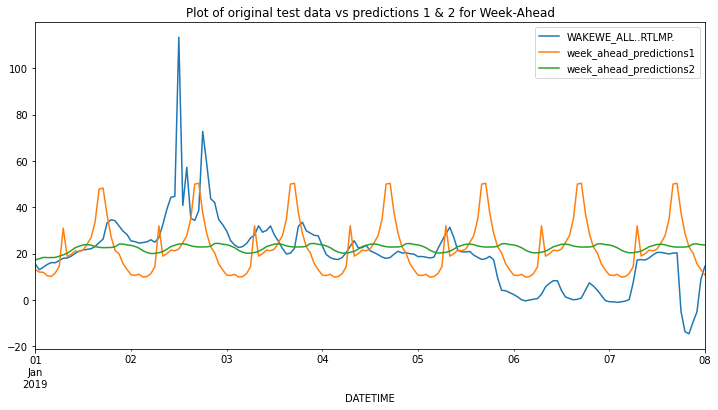

In [133]:
test2.plot(legend=True,figsize=(12,6))
plt.title('Plot of original test data vs predictions 1 & 2 for Week-Ahead')
plt.show()

In [132]:
test2 = df2[['WAKEWE_ALL..RTLMP.']].iloc[8759:8928]
start=len(train1)
end=len(train1)+len(test2)-1
week_ahead_predictions1 = results1.predict(start=start, end=end, dynamic=False,
                                typ='levels').rename('Predictions from model on original data')
week_ahead_predictions2 = results2.predict(start=start, end=end, dynamic=False,
                                typ='levels').rename('Predictions from model on transformed data')
test2['week_ahead_predictions1'] = week_ahead_predictions1
test2['week_ahead_predictions2'] = week_ahead_predictions2
test2.iloc[120:169,].style.set_table_attributes('style="font-size: 16px"')

,WAKEWE_ALL..RTLMP.,week_ahead_predictions1,week_ahead_predictions2
DATETIME,,,
2019-01-06 00:00:00,2.327500,10.730414,23.720238
2019-01-06 01:00:00,1.302500,10.506359,23.230758
2019-01-06 02:00:00,0.037500,11.032136,22.512836
2019-01-06 03:00:00,-0.425000,9.843263,21.452566
2019-01-06 04:00:00,-0.055000,10.062408,20.704124
2019-01-06 05:00:00,0.282500,11.357023,20.272887
2019-01-06 06:00:00,0.570000,14.312104,20.330742
2019-01-06 07:00:00,2.465000,31.981992,20.586286
2019-01-06 08:00:00,5.605000,18.886037,21.043013


In [134]:
err1 = smape(test2['WAKEWE_ALL..RTLMP.'], week_ahead_predictions1)
err2 = smape(test2['WAKEWE_ALL..RTLMP.'], week_ahead_predictions2)
print('SMAPE for ARIMA on the original data: ', "{:.4}%".format(err1))
print('SMAPE for ARIMA on the transformed data:' ,"{:.4}%".format(err2))

SMAPE for ARIMA on the original data:  72.71%
SMAPE for ARIMA on the transformed data: 57.61%


In [135]:
forecast = results1.get_forecast(168)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.2)
yhat_conf_int['true'] = test2['WAKEWE_ALL..RTLMP.']
yhat_conf_int['length'] = yhat_conf_int['upper WAKEWE_ALL..RTLMP.'] - yhat_conf_int['lower WAKEWE_ALL..RTLMP.']
ols_correct1 = np.mean(
    yhat_conf_int['true'].between(yhat_conf_int['lower WAKEWE_ALL..RTLMP.'], yhat_conf_int['upper WAKEWE_ALL..RTLMP.']))
print(f"{ols_correct1:.2%} of the prediction intervals contain true target.")
print('The average prediction interval length for ARIMA on the original data: ', yhat_conf_int['length'].mean())

99.40% of the prediction intervals contain true target.
The average prediction interval length for ARIMA on the original data:  162.97456918900428


In [136]:
forecast = results2.get_forecast(168)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.2)
#print(yhat)
yhat_conf_int['true'] = test2['WAKEWE_ALL..RTLMP.']
yhat_conf_int['length'] = yhat_conf_int['upper Median Smooth'] - yhat_conf_int['lower Median Smooth']
ols_correct1 = np.mean(
    yhat_conf_int['true'].between(yhat_conf_int['lower Median Smooth'], yhat_conf_int['upper Median Smooth']))
print(f"{ols_correct1:.2%} of the prediction intervals contain true target.")
print('The average prediction interval length for ARIMA on the transformed data: ',yhat_conf_int['length'].mean())

94.64% of the prediction intervals contain true target.
The average prediction interval length for ARIMA on the transformed data:  54.04476953929772
